import modules

In [1]:
# @title imports
from typing import Callable, List, Tuple
import sys
sys.path.insert(0, '../abc')
import torch as t
from torch.distributions import normal, uniform
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import Image
from IPython import display
from tqdm import tqdm
import time
from model import init_grids, model
from vis_utils import visualize_batch, visualize_sequence
from utils import chop_and_shuffle_data
from helpers import gaussian_pdf
from distance_funcs import S1, mean_sq_distance

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def abc_prc(
    X: t.Tensor,
    Y_obs: t.Tensor,
    model,
    mu_1,
    kernel: Callable[[t.Tensor], t.Tensor],
    distance_func,
    epsilons: List[float],
    N: int,
) -> Tuple[t.Tensor, List[t.Tensor], float]:
    """
    Perform approximate Bayesian computation through Sequential Monte Carlo with Particle
    Rejection Control as defined in https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104.

    X:              The Model inputs.
    Y_obs:          The observed outputs (based on the inputs).
    model:          The Model.
    mu_1:           Initial sampling distribution over theta.
    kernel:         Markov transition kernel to move theta.
    distance_func:  Calculates the distance between two sets of observations (given a set of inputs).
    epsilons:       A list of increasingly stricter distance thresholds.
    """
    data_gen_hist = []
    thetas = mu_1(N)
    theta_hist = [thetas.detach().clone().numpy()]
    for _, epsilon in enumerate(epsilons):
        print(f'epsilon: {epsilon}')
        for i in tqdm(range(N)):
            close_enough = False
            theta_star = theta_ss = Y_sim = None
            n_data_generations = 0
            while not close_enough:
                # Sample from previous population
                theta_star = thetas[t.randint(len(thetas), (1,))]
                # Move the particle with a gaussian markov kernel
                theta_ss = kernel(theta_star)
                # sample Y_sim using beta**
                Y_sim = model(X, theta_ss)
                n_data_generations += 1
                # check the distance
                close_enough = distance_func(X, Y_sim, Y_obs) <= epsilon
            thetas[i] = theta_ss.detach().clone()
            data_gen_hist.append(n_data_generations)
        theta_hist.append(thetas.detach().clone().numpy())
    return thetas, theta_hist, data_gen_hist

In [3]:
grid_size = 30 
num_sequences = 500
steps_per_sequence = 15 
mu = t.tensor(0.5) 
sigma = t.tensor(0.1) 

frame_speed = 0.1 

In [4]:
sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
betas = []

# @title generate dataset
for seq_idx in tqdm(range(num_sequences)):
  sequence = init_grids(grid_size,1)
  for step_idx in range(steps_per_sequence):
    beta = t.clip(normal.Normal(mu, sigma).sample(), 0, 1)
    sequences[seq_idx,step_idx,:,:] = sequence
    sequence = model(sequence, beta)
    betas.append(beta.detach().cpu())

dataset = chop_and_shuffle_data(sequences)

100%|██████████| 500/500 [00:05<00:00, 95.02it/s] 


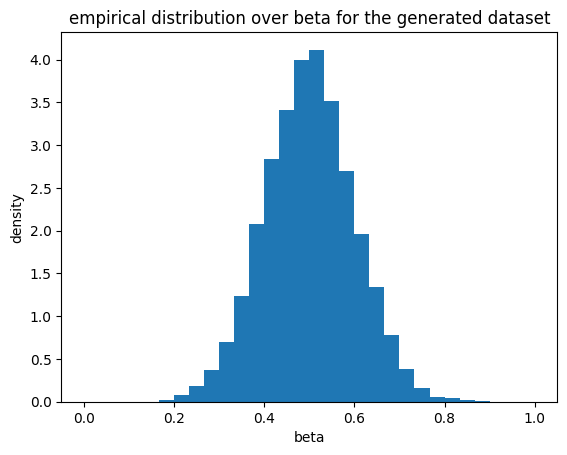

tensor(0.5004)


In [5]:
plt.hist(betas, density=True, range=(0,1), bins=30)
plt.title("empirical distribution over beta for the generated dataset")
plt.xlabel("beta")
plt.ylabel("density")
plt.show()
print(t.mean(t.tensor(betas)))

In [5]:
def calc_distance(X, Y_sim:t.Tensor, Y_obs:t.Tensor) -> t.Tensor:
  # get statistics of the simulated set
  s_sim = S1(X, Y_sim)
  # get statistics of the observed set
  s_obs = S1(X, Y_obs)
  # calculate the mean ratio
  return (1 - t.mean(s_sim / (s_obs+1)))**2

In [7]:
X = dataset[:,0]
Y_obs = dataset[:,1]
calc_distance(X, Y_obs, model(X,0.5))

tensor(0.0015, dtype=torch.float64)

In [8]:
# @title Run ABC-PRC for the example { vertical-output: true}
N = 2_000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilons = [0.6, 0.2, 0.05, 0.005]
mu_1 = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample_n

def kernel(beta:t.Tensor):
    return normal.Normal(beta, 0.1).sample()

betas, beta_hist, data_gen_hist = abc_prc(X, Y_obs, model, mu_1, kernel, calc_distance, epsilons, N)

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


epsilon: 0.6


100%|██████████| 2000/2000 [09:34<00:00,  3.48it/s]


epsilon: 0.2


100%|██████████| 2000/2000 [09:47<00:00,  3.41it/s]


epsilon: 0.05


100%|██████████| 2000/2000 [13:36<00:00,  2.45it/s]


epsilon: 0.005


100%|██████████| 2000/2000 [24:36<00:00,  1.35it/s] 


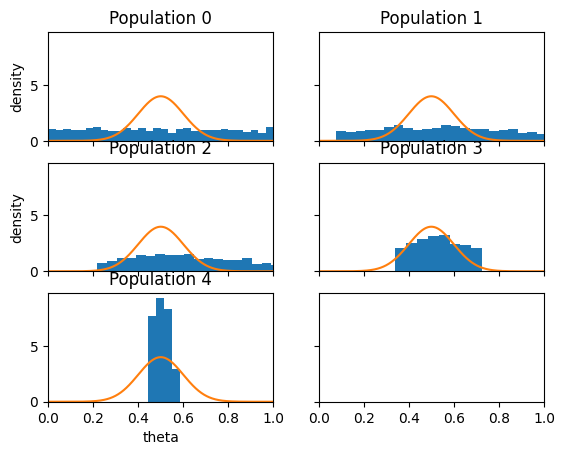

In [12]:
beta_pdf = gaussian_pdf(mu, sigma**2)

x_vis = t.linspace(0,1,1_000)
y_vis = beta_pdf(x_vis)

fig, axs = plt.subplots(3,2, sharex=True, sharey=True)

axs[0,0].hist(beta_hist[0], density=True, bins=30)
axs[0,0].plot(x_vis, y_vis)
axs[0,0].set(ylabel='density', title="Population 0")
axs[0,1].hist(beta_hist[1], density=True, bins=30)
axs[0,1].plot(x_vis, y_vis)
axs[0,1].set(title="Population 1")
axs[1,0].hist(beta_hist[2], density=True, bins=30)
axs[1,0].plot(x_vis, y_vis)
axs[1,0].set( ylabel='density', title="Population 2")
axs[1,1].hist(beta_hist[3], density=True, bins=30)
axs[1,1].plot(x_vis, y_vis)
axs[1,1].set( title="Population 3")
axs[2,0].hist(beta_hist[4], density=True, bins=40)
axs[2,0].plot(x_vis, y_vis)
axs[2,0].set(xlabel='theta', title="Population 4")

plt.xlim(0,1)
plt.show()

In [14]:
# @title Run ABC-PRC for the example { vertical-output: true}
N = 1_000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilons = [0.6, 0.2, 0.05, 0.05, 0.05]
mu_1 = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample_n

def kernel(beta:t.Tensor):
    return normal.Normal(beta, 0.1).sample()

betas, beta_hist, data_gen_hist = abc_prc(X, Y_obs, model, mu_1, kernel, calc_distance, epsilons, N)

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


epsilon: 0.6


100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


epsilon: 0.2


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


epsilon: 0.05


100%|██████████| 1000/1000 [08:42<00:00,  1.91it/s]


epsilon: 0.05


100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]


epsilon: 0.05


100%|██████████| 1000/1000 [06:22<00:00,  2.62it/s]


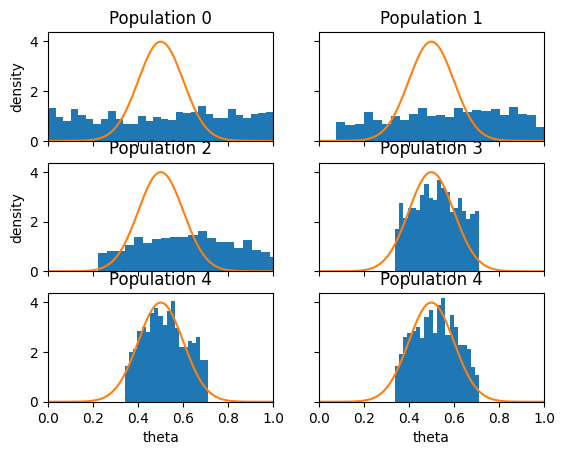

In [15]:
beta_pdf = gaussian_pdf(mu, sigma**2)

x_vis = t.linspace(0,1,1_000)
y_vis = beta_pdf(x_vis)

fig, axs = plt.subplots(3,2, sharex=True, sharey=True)

axs[0,0].hist(beta_hist[0], density=True, bins=30)
axs[0,0].plot(x_vis, y_vis)
axs[0,0].set(ylabel='density', title="Population 0")
axs[0,1].hist(beta_hist[1], density=True, bins=30)
axs[0,1].plot(x_vis, y_vis)
axs[0,1].set(title="Population 1")
axs[1,0].hist(beta_hist[2], density=True, bins=30)
axs[1,0].plot(x_vis, y_vis)
axs[1,0].set( ylabel='density', title="Population 2")
axs[1,1].hist(beta_hist[3], density=True, bins=20)
axs[1,1].plot(x_vis, y_vis)
axs[1,1].set( title="Population 3")
axs[2,0].hist(beta_hist[4], density=True, bins=20)
axs[2,0].plot(x_vis, y_vis)
axs[2,0].set(xlabel='theta', title="Population 4")
axs[2,1].hist(beta_hist[5], density=True, bins=20)
axs[2,1].plot(x_vis, y_vis)
axs[2,1].set(xlabel='theta', title="Population 4")

plt.xlim(0,1)
plt.show()

In [28]:
len(data_gen_hist)
for i in range(1,6):
    min_idx = (i - 1) * 1000
    max_idx = i * 1000
    print(t.sum(t.tensor(data_gen_hist, dtype=t.float)[min_idx:max_idx])/1000)

tensor(1.0770)
tensor(1.0780)
tensor(1.6450)
tensor(1.2380)
tensor(1.1860)


In [29]:
# @title Run ABC-PRC for the example { vertical-output: true}
N = 1_000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilons = [0.6, 0.2, 0.05, 0.01, 0.01]
mu_1 = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample_n

def kernel(beta:t.Tensor):
    return normal.Normal(beta, 0.1).sample()

betas, beta_hist, data_gen_hist = abc_prc(X, Y_obs, model, mu_1, kernel, calc_distance, epsilons, N)

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


epsilon: 0.6


100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


epsilon: 0.2


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


epsilon: 0.05


100%|██████████| 1000/1000 [07:24<00:00,  2.25it/s]


epsilon: 0.01


100%|██████████| 1000/1000 [09:14<00:00,  1.80it/s]


epsilon: 0.01


100%|██████████| 1000/1000 [08:24<00:00,  1.98it/s]


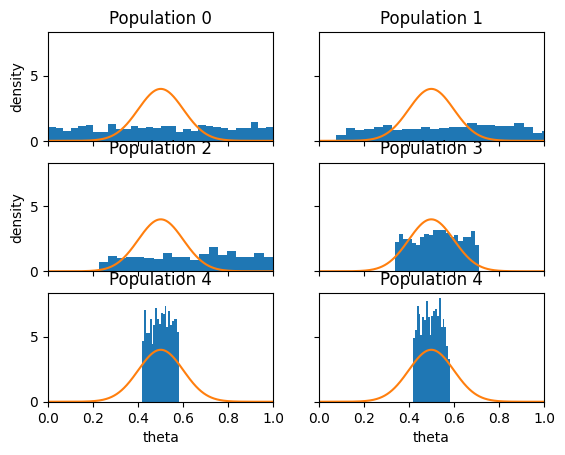

In [30]:
beta_pdf = gaussian_pdf(mu, sigma**2)

x_vis = t.linspace(0,1,1_000)
y_vis = beta_pdf(x_vis)

fig, axs = plt.subplots(3,2, sharex=True, sharey=True)

axs[0,0].hist(beta_hist[0], density=True, bins=30)
axs[0,0].plot(x_vis, y_vis)
axs[0,0].set(ylabel='density', title="Population 0")
axs[0,1].hist(beta_hist[1], density=True, bins=30)
axs[0,1].plot(x_vis, y_vis)
axs[0,1].set(title="Population 1")
axs[1,0].hist(beta_hist[2], density=True, bins=30)
axs[1,0].plot(x_vis, y_vis)
axs[1,0].set( ylabel='density', title="Population 2")
axs[1,1].hist(beta_hist[3], density=True, bins=20)
axs[1,1].plot(x_vis, y_vis)
axs[1,1].set( title="Population 3")
axs[2,0].hist(beta_hist[4], density=True, bins=20)
axs[2,0].plot(x_vis, y_vis)
axs[2,0].set(xlabel='theta', title="Population 4")
axs[2,1].hist(beta_hist[5], density=True, bins=20)
axs[2,1].plot(x_vis, y_vis)
axs[2,1].set(xlabel='theta', title="Population 4")

plt.xlim(0,1)
plt.show()

In [31]:
len(data_gen_hist)
for i in range(1,6):
    min_idx = (i - 1) * 1000
    max_idx = i * 1000
    print(t.sum(t.tensor(data_gen_hist, dtype=t.float)[min_idx:max_idx])/1000)

tensor(1.0670)
tensor(1.0830)
tensor(1.7190)
tensor(2.1030)
tensor(1.8910)


# SGLD

In [38]:
class STEFunction(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [39]:
from likelihoods import spread_likelihood

def model_STE(grids: t.Tensor, beta: t.Tensor) -> t.Tensor:
    # produces a mask that is 1 for all healthy cells, 0 for the infected cells
    healthy_mask = 1 - grids
    # calculate the likelihood of spread 
    likelihoods = spread_likelihood(grids, beta)
    # compare each likelihood to a random value ~ U(0,1) to get the residual values
    if grids.is_cuda:
        residuals = likelihoods - t.rand(*grids.shape).cuda()
    else:
        residuals = likelihoods - t.rand(*grids.shape)
    # apply the heaviside to the residuals,
    #   if the residual is positive, the cell should be infected ( < spread_likelihood)
    #   if the residual is negative, the cell should stay healthy ( > spread_likelihood)
    #   if the cell was already infected, no update should be applied 
    update_mask = STEFunction.apply(residuals) * healthy_mask
    # apply the update to the current state
    return grids + update_mask

In [40]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], 0

In [41]:
training_data = CustomDataset(dataset)
len(training_data)
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)

In [42]:
from torch.optim.optimizer import Optimizer, required

class SGLD(Optimizer):
    """Implements SGLD algorithm based on
        https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf

    Built on the PyTorch SGD implementation
    (https://github.com/pytorch/pytorch/blob/v1.4.0/torch/optim/sgd.py)
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGLD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGLD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(p.data, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state[
                            'momentum_buffer'] = t.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(d_p, alpha=-group['lr'])
                noise_std = t.Tensor([2*group['lr']]).cuda()
                noise_std = noise_std.sqrt()
                noise = p.data.new(
                    p.data.size()).normal_(mean=0, std=1)*noise_std
                p.data.add_(noise.item())

        return 1.0

In [43]:
class LangevinDynamics(object):
    def __init__(self, beta, lr=1e-2, lr_final=1e-4, max_itr=1e4):
        super(LangevinDynamics, self).__init__()

        self.beta = beta
        self.optim = SGLD([self.beta], lr, weight_decay=0.0)
        self.lr = lr
        self.lr_final = lr_final
        self.max_itr = max_itr
        self.lr_fn = self.decay_fn(lr=lr, lr_final=lr_final, max_itr=max_itr)
        self.counter = 0.0

    def sample(self, X:t.Tensor, Y_obs:t.Tensor):
        self.lr_decay()
        self.optim.zero_grad()
        Y_sim = model_STE(X, beta)
        dist = mean_sq_distance(X, Y_sim, Y_obs)
        dist.backward()
        self.optim.step()
        self.counter += 1
        return self.beta.detach().clone().cpu(), dist.item()

    def decay_fn(self, lr=1e-2, lr_final=1e-4, max_itr=1e4):
        gamma = -0.55
        b = max_itr/((lr_final/lr)**(1/gamma) - 1.0)
        a = lr/(b**gamma)
        def lr_fn(t, a=a, b=b, gamma=gamma):
            return a*((b + t)**gamma)
        return lr_fn

    def lr_decay(self):
        for param_group in self.optim.param_groups:
            param_group['lr'] = self.lr_fn(self.counter)

In [59]:
import math 

beta = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
beta = beta.cuda()
beta.requires_grad_()
epochs = 600

langevin_dynamics = LangevinDynamics(
    beta,
    lr=1e-6,
    lr_final=1e-7,
    max_itr=math.ceil(len(training_data) / training_loader.batch_size) * epochs ,
)

def train_loop(dataloader):
    size = len(dataloader.dataset)
    betas = []
    for batch, (transitions, y) in enumerate(dataloader):
        X = transitions[:, 0]
        X = X.cuda()
        Y_obs = transitions[:, 1]
        Y_obs = Y_obs.cuda()
        beta, dist = langevin_dynamics.sample(X, Y_obs)
        betas.append(beta)
    return betas

In [60]:
betas = []
for epoch in tqdm(range(600)):
    betas = betas + train_loop(training_loader)
print("Done!")

100%|██████████| 600/600 [07:36<00:00,  1.31it/s]

Done!


131400
tensor(0.2286)


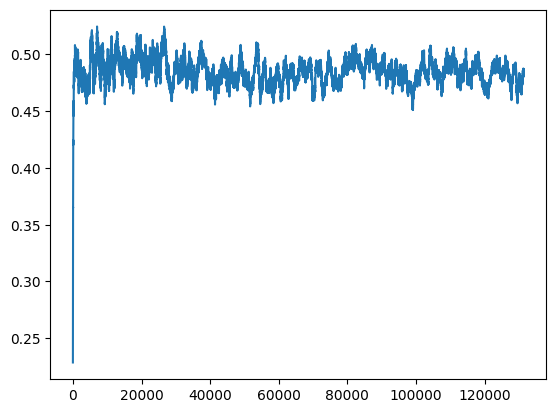

In [61]:
print(len(betas))
print(betas[0])
plt.plot(np.arange(len(betas)), betas)

(0.0, 1.0)

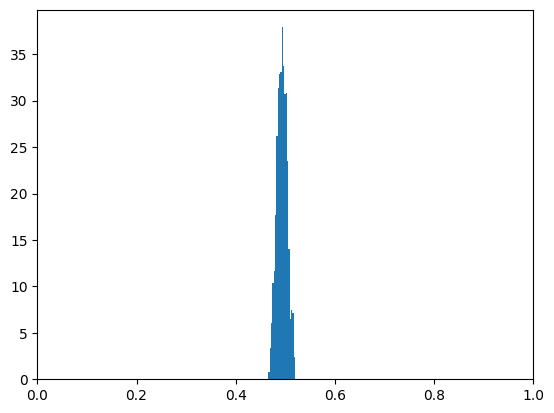

In [62]:
plt.hist(betas[10_000:20_000], density=True, bins=20)
plt.xlim(0.,1.)

In [63]:
betas = t.linspace(0.0, 1.0, 1000)
betas = betas.cuda()
X = dataset[:,0]
X = X.cuda()
Y_obs = dataset[:,1]
Y_obs = Y_obs.cuda()
grads = []
for beta in tqdm(betas):
    beta.requires_grad_()
    Y_sim = model_STE(X, beta)
    dist = calc_distance(X, Y_sim, Y_obs)
    gradient = t.autograd.grad(dist, beta)[0]
    grads.append(gradient.detach().clone())

100%|██████████| 1000/1000 [02:19<00:00,  7.17it/s]


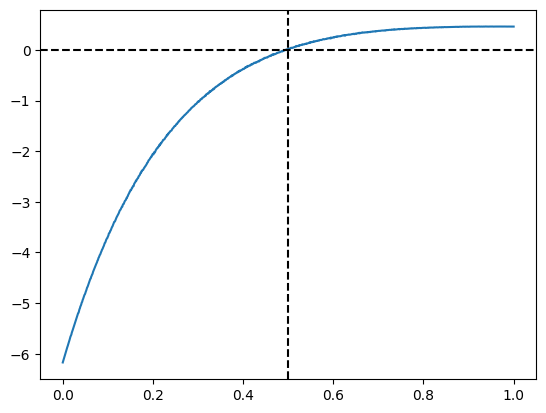

In [65]:
plt.plot(betas.cpu(), t.tensor(grads).cpu())
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.axvline(x = 0.5, color = 'black', linestyle = '--')

replace the mean squared distance with the distance func used for PRC

In [116]:
from torch.optim.optimizer import Optimizer, required

class SGLD(Optimizer):
    """Implements SGLD algorithm based on
        https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf

    Built on the PyTorch SGD implementation
    (https://github.com/pytorch/pytorch/blob/v1.4.0/torch/optim/sgd.py)
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGLD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGLD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(p.data, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state[
                            'momentum_buffer'] = t.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                #print(f"p: {p}")
                #val = p * -group["lr"]
                #print(f"grad * lr: {val}")
                p.data.add_(d_p, alpha=-group['lr'])
                noise = p.data.new(
                    p.data.size()).normal_(mean=0, std=0.05)
                #print(f"noise: {noise}")
                p.data.add_(noise.item())
                p.data.clamp_(0.,1.)
                

        return 1.0

In [117]:
class LangevinDynamics(object):
    def __init__(self, beta, lr=1e-2, lr_final=1e-4, max_itr=1e4):
        super(LangevinDynamics, self).__init__()

        self.beta = beta
        self.optim = SGLD([self.beta], lr, weight_decay=0.0)
        self.lr = lr
        self.lr_final = lr_final
        self.max_itr = max_itr
        self.lr_fn = self.decay_fn(lr=lr, lr_final=lr_final, max_itr=max_itr)
        self.counter = 0.0

    def sample(self, X:t.Tensor, Y_obs:t.Tensor):
        self.lr_decay()
        self.optim.zero_grad()
        Y_sim = model_STE(X, beta)
        dist = calc_distance(X, Y_sim, Y_obs)
        dist.backward()
        self.optim.step()
        self.counter += 1
        return self.beta.detach().clone().cpu(), dist.item()

    def decay_fn(self, lr=1e-2, lr_final=1e-4, max_itr=1e4):
        gamma = -0.55
        b = max_itr/((lr_final/lr)**(1/gamma) - 1.0)
        a = lr/(b**gamma)
        def lr_fn(t, a=a, b=b, gamma=gamma):
            return a*((b + t)**gamma)
        return lr_fn

    def lr_decay(self):
        for param_group in self.optim.param_groups:
            param_group['lr'] = self.lr_fn(self.counter)

In [133]:
import math 

beta = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
beta = beta.cuda()
beta.requires_grad_()
epochs = 600

langevin_dynamics = LangevinDynamics(
    beta,
    lr=0.1,
    lr_final=0.05,
    max_itr=math.ceil(len(training_data) / training_loader.batch_size) * epochs ,
)

def train_loop(dataloader):
    size = len(dataloader.dataset)
    betas = []
    for batch, (transitions, y) in enumerate(dataloader):
        X = transitions[:, 0]
        X = X.cuda()
        Y_obs = transitions[:, 1]
        Y_obs = Y_obs.cuda()
        beta, dist = langevin_dynamics.sample(X, Y_obs)
        betas.append(beta)
    return betas

In [122]:
betas = []
for epoch in tqdm(range(15)):
    betas = betas + train_loop(training_loader)
print("Done!")

100%|██████████| 15/15 [00:11<00:00,  1.34it/s]

Done!


3285
tensor(0.5356)


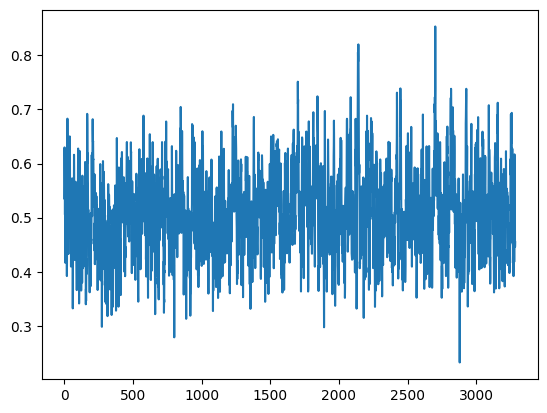

In [123]:
print(len(betas))
print(betas[0])
plt.plot(np.arange(len(betas)), betas)

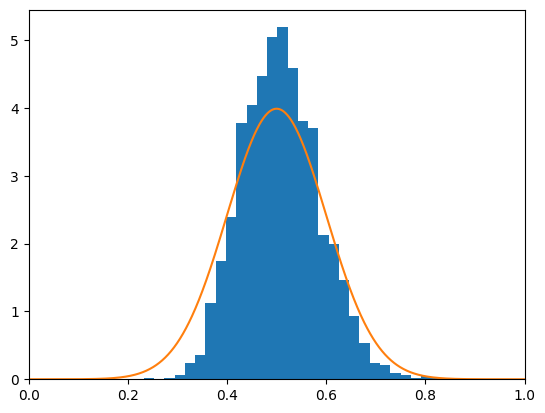

In [125]:
plt.hist(betas, density=True, bins=30)
plt.xlim(0.,1.)

beta_pdf = gaussian_pdf(mu, sigma**2)
x_vis = t.linspace(0,1,1_000)
y_vis = beta_pdf(x_vis)
plt.plot(x_vis, y_vis)

plt.show()

different beta distribution

In [126]:
grid_size = 30 
num_sequences = 500
steps_per_sequence = 15 
mu = t.tensor(0.2) 
sigma = t.tensor(0.01) 

frame_speed = 0.1 

In [127]:
sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
betas = []

# @title generate dataset
for seq_idx in tqdm(range(num_sequences)):
  sequence = init_grids(grid_size,1)
  for step_idx in range(steps_per_sequence):
    beta = t.clip(normal.Normal(mu, sigma).sample(), 0, 1)
    sequences[seq_idx,step_idx,:,:] = sequence
    sequence = model(sequence, beta)
    betas.append(beta.detach().cpu())

dataset = chop_and_shuffle_data(sequences)

100%|██████████| 500/500 [00:05<00:00, 89.95it/s]


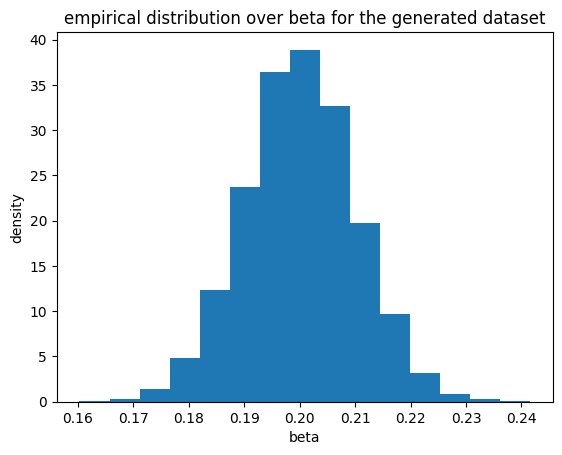

tensor(0.2001)


In [130]:
plt.hist(betas, density=True, bins=15)
plt.title("empirical distribution over beta for the generated dataset")
plt.xlabel("beta")
plt.ylabel("density")
plt.show()
print(t.mean(t.tensor(betas)))

In [131]:
training_data = CustomDataset(dataset)
len(training_data)
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)

In [153]:
from torch.optim.optimizer import Optimizer, required

class SGLD(Optimizer):
    """Implements SGLD algorithm based on
        https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf

    Built on the PyTorch SGD implementation
    (https://github.com/pytorch/pytorch/blob/v1.4.0/torch/optim/sgd.py)
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGLD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGLD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(p.data, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state[
                            'momentum_buffer'] = t.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(d_p, alpha=-group['lr'])
                noise_std = t.Tensor([2*group['lr']]).cuda()
                noise_std = noise_std.sqrt()
                noise = p.data.new(
                    p.data.size()).normal_(mean=0, std=1)*noise_std
                p.data.add_(noise.item())
                p.data.clamp_(0.,1.)
                

        return 1.0

In [182]:
class LangevinDynamics(object):
    def __init__(self, beta, lr=1e-2, lr_final=1e-4, max_itr=1e4):
        super(LangevinDynamics, self).__init__()

        self.beta = beta
        self.optim = SGLD([self.beta], lr, weight_decay=0.0)
        self.lr = lr
        self.lr_final = lr_final
        self.max_itr = max_itr
        self.lr_fn = self.decay_fn(lr=lr, lr_final=lr_final, max_itr=max_itr)
        self.counter = 0.0

    def sample(self, X:t.Tensor, Y_obs:t.Tensor):
        self.optim.zero_grad()
        Y_sim = model_STE(X, beta)
        dist = calc_distance(X, Y_sim, Y_obs)
        dist.backward()
        self.optim.step()
        self.counter += 1
        return self.beta.detach().clone().cpu(), dist.item()

    def decay_fn(self, lr=1e-2, lr_final=1e-4, max_itr=1e4):
        gamma = -0.55
        b = max_itr/((lr_final/lr)**(1/gamma) - 1.0)
        a = lr/(b**gamma)
        def lr_fn(t, a=a, b=b, gamma=gamma):
            return a*((b + t)**gamma)
        return lr_fn

    def lr_decay(self):
        for param_group in self.optim.param_groups:
            param_group['lr'] = self.lr_fn(self.counter)

In [198]:
beta = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
beta = beta.cuda()
beta.requires_grad_()
epochs = 20


langevin_dynamics = LangevinDynamics(
    beta,
    lr=0.0001,
    lr_final=0.00001,
    max_itr=epochs ,
)

def train_loop(dataloader):
    size = len(dataloader.dataset)
    betas = []
    for batch, (transitions, y) in enumerate(dataloader):
        X = transitions[:, 0]
        X = X.cuda()
        Y_obs = transitions[:, 1]
        Y_obs = Y_obs.cuda()
        beta, dist = langevin_dynamics.sample(X, Y_obs)
        betas.append(beta)
    return betas

In [199]:
betas = []
for epoch in tqdm(range(20)):
    langevin_dynamics.lr_decay()
    betas = betas + train_loop(training_loader)
print("Done!")

100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

Done!


4380
tensor(0.9646)


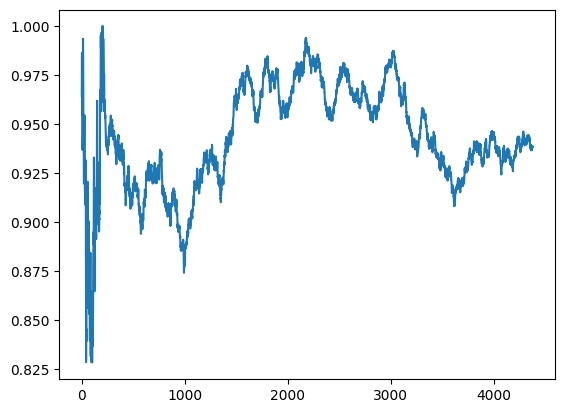

In [200]:
print(len(betas))
print(betas[0])
plt.plot(np.arange(len(betas)), betas)

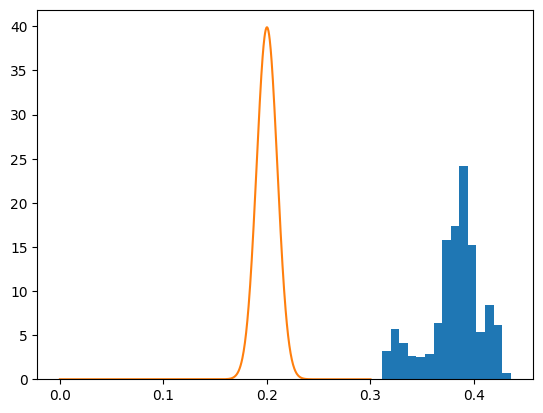

In [197]:
plt.hist(betas[1000:], density=True, bins=15)

beta_pdf = gaussian_pdf(mu, sigma**2)
x_vis = t.linspace(0,0.3,1_000)
y_vis = beta_pdf(x_vis)
plt.plot(x_vis, y_vis)

plt.show()